### Обучение нейросети

In [1]:
%pip install -r requirements.txt

  Using cached llvmlite-0.44.0-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached numba-0.61.0-cp312-cp312-win_amd64.whl.metadata (2.8 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
Using cached llvmlite-0.44.0-cp312-cp312-win_amd64.whl (30.3 MB)
Using cached numba-0.61.0-cp312-cp312-win_amd64.whl (2.8 MB)
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
Note: you may need to restart the kernel to use updated packages.


In [19]:
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dataset

#### Импортируем датасет

In [ ]:
df = dataset.load_dataset()
df

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel
...,...,...,...,...
1387,1387,http://www.electroshops.com/,electroshops home theater decor interiors seat...,Business/Corporate
1388,1388,http://www.cleanridge.com/,clean ridge soap company clean ridge soap comp...,Business/Corporate
1389,1389,http://www.creativepetgifts.com/,home page pet crafts exquisitely piece handcut...,Business/Corporate
1390,1390,http://www.htmarket.com/,home theater marketplace home theater seating ...,Business/Corporate


### Обучаем Word2Vec модель

In [6]:
sentences = [text.split() for text in df['cleaned_website_text']]  # Adjust based on your token format

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

### Создаем векторы для каждого документа

In [7]:
def document_vector(model, doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv]
    if not doc:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

X = np.array([document_vector(model, doc) for doc in sentences])
y = df['Category'].values  # Your labels

## Визуализация векторов

#### t-SNE

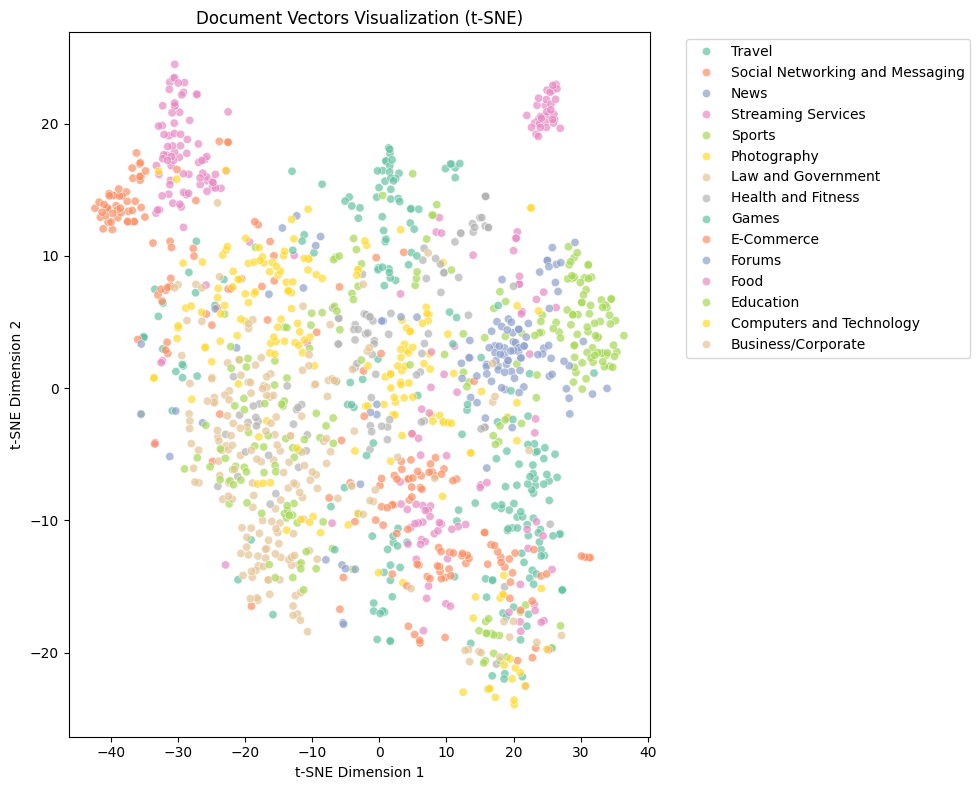

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
vectors_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=vectors_tsne[:, 0], y=vectors_tsne[:, 1], 
                hue=df['Category'], palette='Set2', alpha=0.7)
plt.title('Document Vectors Visualization (t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### PSA

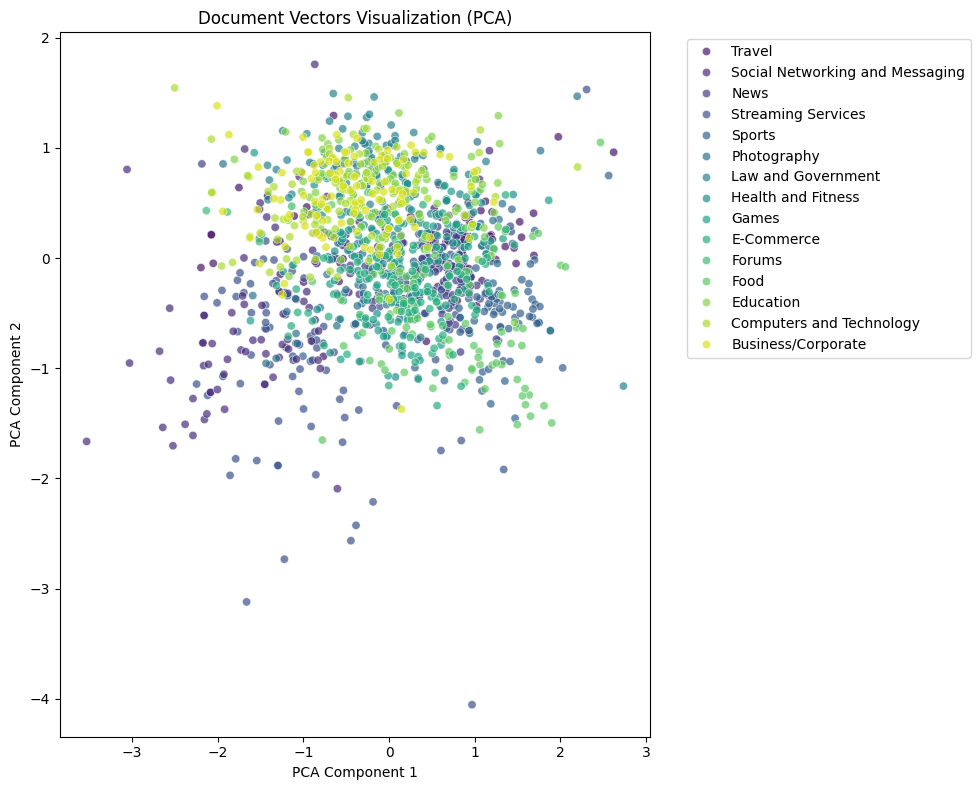

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(X) 

plt.figure(figsize=(10, 8))
sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], 
                hue=df['Category'], palette='viridis', alpha=0.7)
plt.title('Document Vectors Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### UMAP

c:\Coding\MyThesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Coding\MyThesis\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


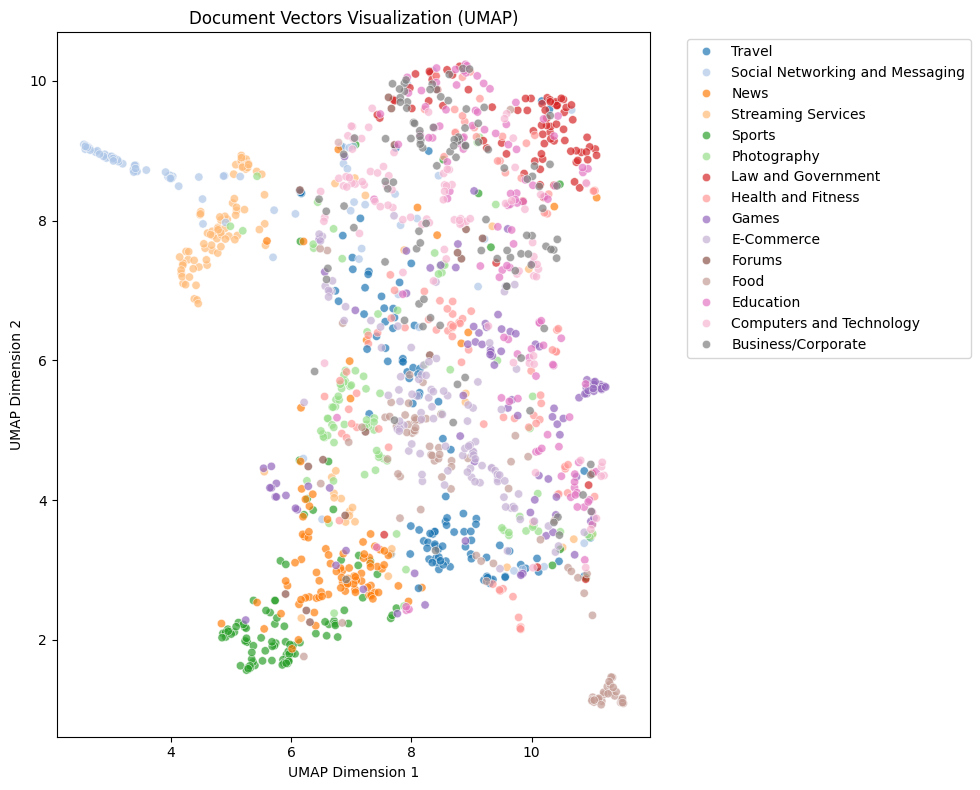

In [10]:
import umap

reducer = umap.UMAP(random_state=42)
vectors_umap = reducer.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=vectors_umap[:, 0], y=vectors_umap[:, 1], 
                hue=df['Category'], palette='tab20', alpha=0.7)
plt.title('Document Vectors Visualization (UMAP)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have X (word2vec document vectors) and y (labels) from previous steps

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the neural network
class TextClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
input_dim = X.shape[1]
num_classes = len(le.classes_)
model = TextClassifier(input_dim, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [12]:
# Training loop
num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss/len(train_loader.dataset):.4f}')
    print(f'Test Loss: {test_loss/len(test_loader.dataset):.4f}')
    print(f'Accuracy: {100 * correct/total:.2f}%')

Epoch 1/200
Train Loss: 2.6679
Test Loss: 2.5995
Accuracy: 20.07%
Epoch 2/200
Train Loss: 2.5283
Test Loss: 2.3569
Accuracy: 34.05%
Epoch 3/200
Train Loss: 2.3023
Test Loss: 2.0493
Accuracy: 45.88%
Epoch 4/200
Train Loss: 2.0375
Test Loss: 1.7697
Accuracy: 48.75%
Epoch 5/200
Train Loss: 1.8264
Test Loss: 1.5848
Accuracy: 58.06%
Epoch 6/200
Train Loss: 1.6793
Test Loss: 1.4416
Accuracy: 60.22%
Epoch 7/200
Train Loss: 1.5267
Test Loss: 1.3117
Accuracy: 67.03%
Epoch 8/200
Train Loss: 1.4549
Test Loss: 1.2675
Accuracy: 65.59%
Epoch 9/200
Train Loss: 1.3721
Test Loss: 1.2193
Accuracy: 66.31%
Epoch 10/200
Train Loss: 1.3486
Test Loss: 1.1835
Accuracy: 69.18%
Epoch 11/200
Train Loss: 1.3085
Test Loss: 1.1486
Accuracy: 71.33%
Epoch 12/200
Train Loss: 1.2789
Test Loss: 1.1528
Accuracy: 68.10%
Epoch 13/200
Train Loss: 1.2142
Test Loss: 1.1168
Accuracy: 68.10%
Epoch 14/200
Train Loss: 1.1979
Test Loss: 1.0952
Accuracy: 69.18%
Epoch 15/200
Train Loss: 1.1726
Test Loss: 1.0830
Accuracy: 69.89%
Epoc